In [54]:
# ref: https://florianwilhelm.info/2017/04/causal_inference_propensity_score/
# ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2907172/
# ref http://egap.org/methods-guides/10-things-you-need-know-about-causal-inference
# ref https://www.quora.com/Are-there-any-good-resources-for-a-propensity-model-building-in-Python
# https://github.com/benmiroglio/pymatch/blob/master/Example.ipynb
# https://www.quora.com/Where-can-I-find-a-good-writeup-about-propensity-models
# https://www.nber.org/econometrics_minicourse_2015/NBERcausalpredictionv111_lecture2.pdf

In [12]:
from math import exp, log

import pandas as pd
import numpy as np
from scipy import stats

from scipy.special import expit

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline 

import seaborn as sns


In [14]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

np.seterr(divide='ignore', invalid='ignore')
np.random.seed(42)

In [15]:
def exp_recovery_time(sex, age, severity, medication):
    return exp(2+0.5*sex+0.03*age+2*severity-1*medication)

def rvs_recovery_time(sex, age, severity, medication, *args):
    return stats.poisson.rvs(exp_recovery_time(sex, age, severity, medication))

In [16]:
N = 10000  # number of observations, i.e. patients
sexes = np.random.randint(0, 2, size=N)  # sex == 1 if male otherwise female
ages_dist = stats.gamma(8, scale=4)
ages = ages_dist.rvs(size=N)
sev_dist = stats.beta(3, 1.5)
severties = sev_dist.rvs(size=N)

/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


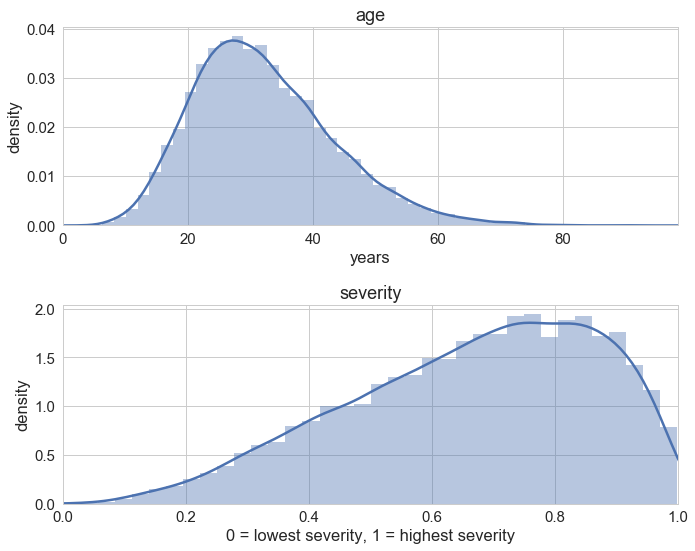

In [17]:
f, (ax1, ax2) = plt.subplots(2)
ax1.set_title('age')
ax1.set_xlabel('years')
ax1.set_ylabel('density')
ax1.set_xlim(0, np.max(ages))
ax2.set_title('severity')
ax2.set_xlabel('0 = lowest severity, 1 = highest severity')
ax2.set_ylabel('density')
ax2.set_xlim(0, 1)
sns.distplot(ages, ax=ax1)
sns.distplot(severties, ax=ax2)
plt.tight_layout();

In [20]:
meds = np.random.randint(0,2,size=N)

In [22]:
const1 = np.ones(N)
df = pd.DataFrame(dict(sex=sexes, age=ages, severity=severties, medication=meds, const=const1 ))


In [23]:
features = ['sex', 'age', 'severity', 'medication', 'const']
df = df[features] # to enforce column order

In [25]:
df['recovery'] = df.apply(lambda x: rvs_recovery_time(*x), axis=1)
df.head()

,sex,age,severity,medication,const,recovery
0,0,24.518667,0.858950,1,1.0,34
1,1,11.080205,0.905123,0,1.0,97
2,0,37.014895,0.601475,0,1.0,77
3,0,35.657701,0.749840,1,1.0,39
4,0,36.735167,0.385460,1,1.0,18


In [26]:
df.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.498700,32.160968,0.666299,0.497400,1.0,76.085700
std,0.500023,11.243333,0.201010,0.500018,0.0,63.304659
min,0.000000,4.508904,0.029818,0.000000,1.0,0.000000
25%,0.000000,24.044093,0.525905,0.000000,1.0,33.000000
50%,0.000000,30.760101,0.693532,0.000000,1.0,57.000000
75%,1.000000,38.922208,0.829290,1.000000,1.0,99.000000
max,1.000000,98.330906,0.999327,1.000000,1.0,805.000000


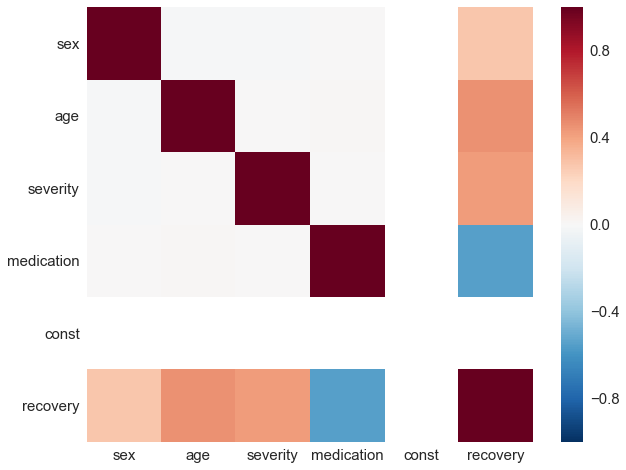

In [27]:
sns.heatmap(df.corr())

In [28]:
glm = sm.GLM(df['recovery'], df[features], family=sm.families.Poisson())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -34429.
Date:                Sat, 09 Feb 2019   Deviance:                       10080.
Time:                        23:29:42   Pearson chi2:                 1.00e+04
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.4994      0.002    211.934      0.000       0.495       0.504
age            0.0301   8.95e-05    335.807      0.000       0.030       0.030
severity       2.0000      0.006    309.610      0.000       1.987       2.013
medication    -1.0024      0.003   -387.721      0.000      -1.007      -0.997
const          1.9990      0.006    326.234      0.000       1.987       2.011
==============================================================================
"""

In [30]:
reg = RandomForestRegressor()
X = df[features].as_matrix()
y = df['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
X_neg = np.copy(X)
# set the medication column to 0
X_neg[:, df.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
# set the medication column to 1
X_pos[:, df.columns.get_loc('medication')] = 1

preds_rnd = reg.predict(X_pos) / reg.predict(X_neg)

/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


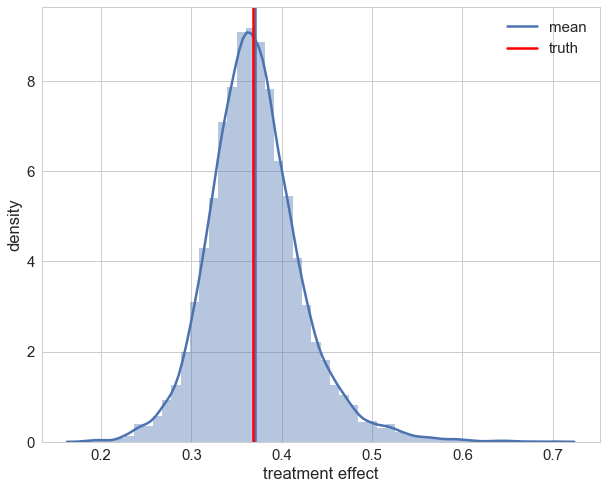

In [33]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

In [34]:
def get_medication(sex, age, severity, medication, *args):
    return int(1/3*sex + 2/3*severity + 0.15*np.random.randn() > 0.8)

df_obs = df.copy().drop('recovery', axis=1)
df_obs['medication'] = df_obs.apply(lambda x: get_medication(*x), axis=1)
df_obs['recovery'] = df_obs.apply(lambda x: rvs_recovery_time(*x), axis=1)
df_obs.describe()

,sex,age,severity,medication,const,recovery
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,0.498700,32.160968,0.666299,0.251900,1.0,85.029100
std,0.500023,11.243333,0.201010,0.434126,0.0,51.400825
min,0.000000,4.508904,0.029818,0.000000,1.0,8.000000
25%,0.000000,24.044093,0.525905,0.000000,1.0,50.000000
50%,0.000000,30.760101,0.693532,0.000000,1.0,73.000000
75%,1.000000,38.922208,0.829290,1.000000,1.0,106.000000
max,1.000000,98.330906,0.999327,1.000000,1.0,624.000000


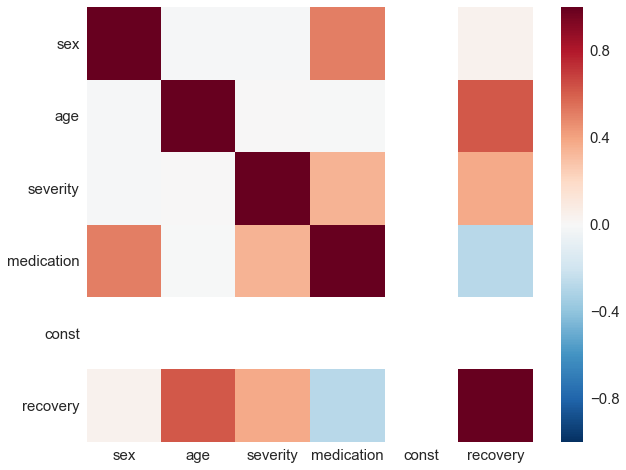

In [35]:
sns.heatmap(df_obs.corr(), vmin=-1, vmax=1);

In [36]:
glm = sm.GLM(df_obs['recovery'], df_obs[features], family=sm.families.Poisson())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -35645.
Date:                Sat, 09 Feb 2019   Deviance:                       10018.
Time:                        23:35:12   Pearson chi2:                 9.98e+03
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.5043      0.002    203.256      0.000       0.499       0.509
age            0.0299   8.58e-05    349.024      0.000       0.030       0.030
severity       1.9996      0.006    313.055      0.000       1.987       2.012
medication    -1.0063      0.003   -302.201      0.000      -1.013      -1.000
const          2.0013      0.006    340.305      0.000       1.990       2.013
==============================================================================
"""

In [37]:
reg = RandomForestRegressor()
X = df_obs[features].as_matrix()
y = df_obs['recovery'].values
reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


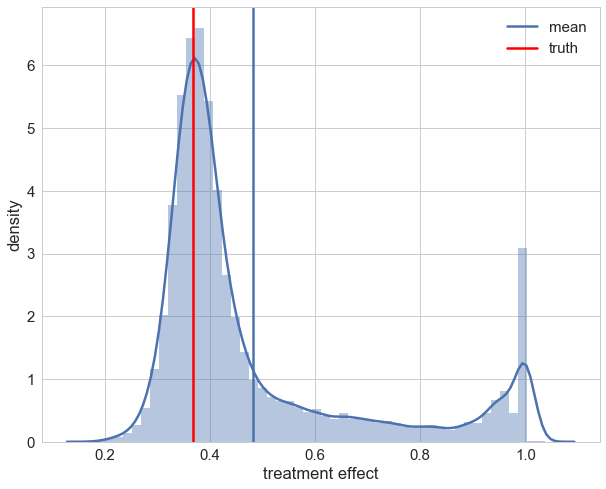

In [38]:
X_neg = np.copy(X)
X_neg[:, df_obs.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
X_pos[:, df_obs.columns.get_loc('medication')] = 1

preds_no_rnd = reg.predict(X_pos) / reg.predict(X_neg)

ax = sns.distplot(preds_no_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_no_rnd), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

In [39]:
# classifier to estimate the propensity score
cls = LogisticRegression(random_state=42)
#cls = GaussianNB()  # another possible propensity score estimator

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = df_obs[features].drop(['medication'], axis=1).as_matrix()
y = df_obs['medication'].values
cls.fit(X, y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            cv=3, method='sigmoid')

In [40]:
propensity = pd.DataFrame(cls.predict_proba(X))
propensity.head()

,0,1
0,0.947430,0.052570
1,0.170632,0.829368
2,0.992034,0.007966
3,0.975970,0.024030
4,0.998434,0.001566


/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


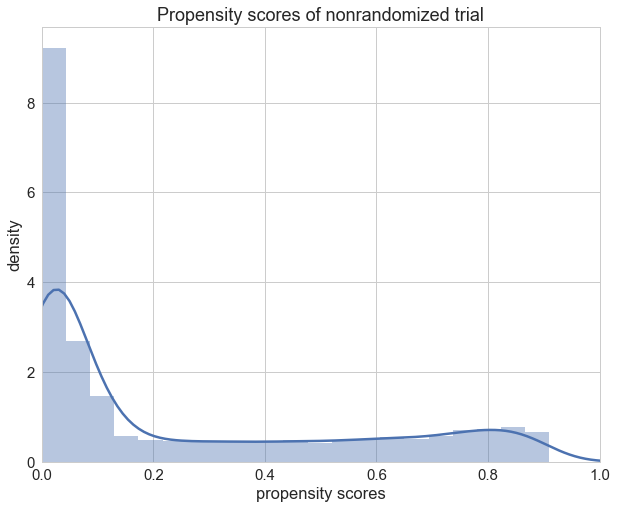

In [41]:
ax = sns.distplot(propensity[1].values)
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of nonrandomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


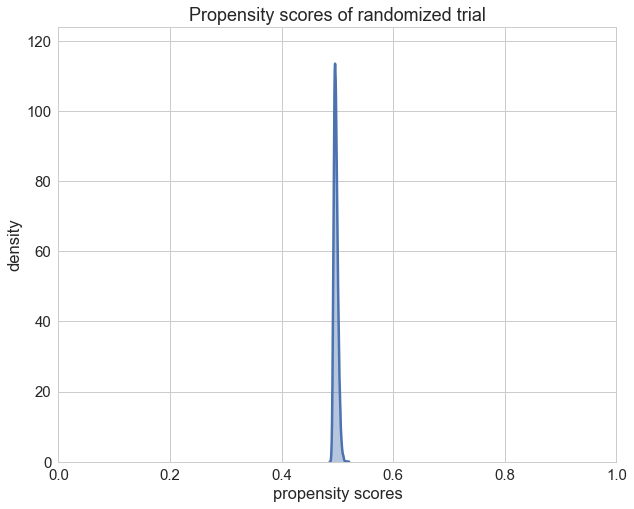

In [42]:
X = df[features].drop(['medication'], axis=1).as_matrix()
y = df['medication'].values
cls.fit(X, y)
ax = sns.distplot(cls.predict_proba(X)[:,1]);
ax.set_xlim(0, 1)
ax.set_title("Propensity scores of randomized trial")
ax.set_xlabel("propensity scores")
ax.set_ylabel('density');

In [43]:
# DataFrame's lookup method extracts the column index provided by df2['medication'] for each row
df_obs['iptw'] = 1. / propensity.lookup(np.arange(propensity.shape[0]), df_obs['medication'])

In [44]:
df_obs.describe()

,sex,age,severity,medication,const,recovery,iptw
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,0.498700,32.160968,0.666299,0.251900,1.0,85.029100,1.860499
std,0.500023,11.243333,0.201010,0.434126,0.0,51.400825,4.455724
min,0.000000,4.508904,0.029818,0.000000,1.0,8.000000,1.000105
25%,0.000000,24.044093,0.525905,0.000000,1.0,50.000000,1.016131
50%,0.000000,30.760101,0.693532,0.000000,1.0,73.000000,1.093217
75%,1.000000,38.922208,0.829290,1.000000,1.0,106.000000,1.449351
max,1.000000,98.330906,0.999327,1.000000,1.0,624.000000,184.561864


In [45]:
glm = sm.GLM(df_obs['recovery'], df_obs[features], 
             family=sm.families.Poisson(),
             freq_weights=df_obs['iptw'])
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               recovery   No. Observations:                10000
Model:                            GLM   Df Residuals:                    18599
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -64795.
Date:                Sat, 09 Feb 2019   Deviance:                       18482.
Time:                        23:41:09   Pearson chi2:                 1.83e+04
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            0.5018      0.002    294.822      0.000       0.498       0.505
age            0.0298   6.56e-05    454.701      0.000       0.030       0.030
severity       2.0016      0.005    429.319      0.000       1.992       2.011
medication    -1.0017      0.002   -534.776      0.000      -1.005      -0.998
const          2.0055      0.005    441.204      0.000       1.997       2.014
==============================================================================
"""

In [46]:
reg = RandomForestRegressor(random_state=42)
X = df_obs[features].as_matrix()
y = df_obs['recovery'].values
reg.fit(X, y, sample_weight=df_obs['iptw'].values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
X_neg = np.copy(X)
X_neg[:, df_obs.columns.get_loc('medication')] = 0
X_pos = np.copy(X)
X_pos[:, df_obs.columns.get_loc('medication')] = 1

preds_propensity = reg.predict(X_pos) / reg.predict(X_neg)

/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


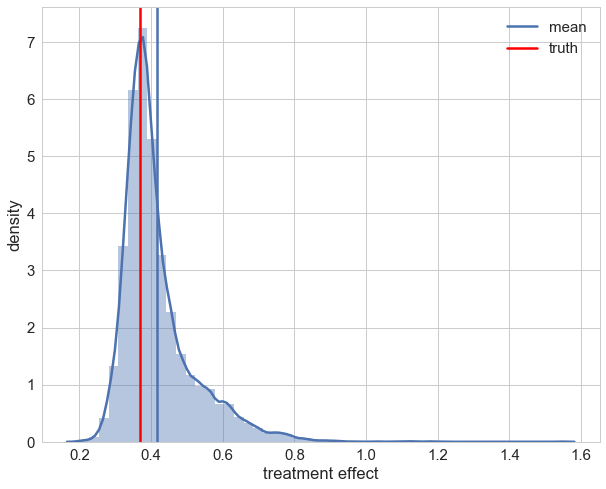

In [48]:
ax = sns.distplot(preds_propensity)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_propensity), label='mean')
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

/Users/sulbha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


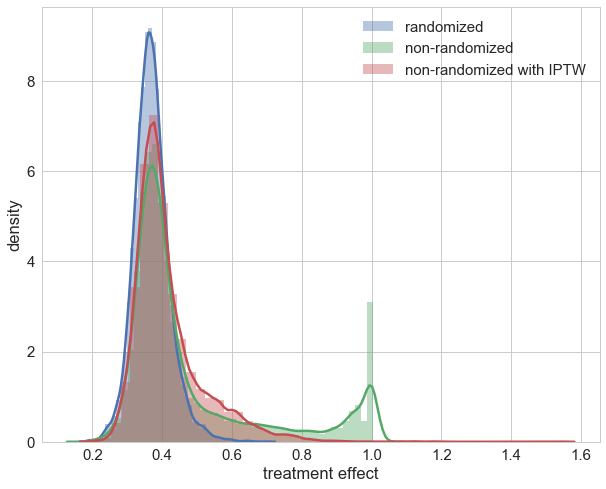

In [49]:
sns.distplot(preds_rnd, label='randomized')
sns.distplot(preds_no_rnd, label='non-randomized')
ax = sns.distplot(preds_propensity, label='non-randomized with IPTW')
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.legend();

In [50]:
def weighted_corr(m, w=None):
    if w is None:
        w = np.ones(m.shape[0])
    cov = np.cov(m, rowvar=False, aweights=w, ddof=0)
    sigma = np.sqrt(np.diag(cov))
    return cov / np.outer(sigma, sigma)

sel_cols = [col for col in df_obs.columns if col != 'iptw']
orig_corr = weighted_corr(df_obs[sel_cols].as_matrix(), w=np.ones(df_obs.shape[0]))
orig_corr = pd.DataFrame(orig_corr, index=sel_cols, columns=sel_cols)
orig_corr

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.013332,-0.012855,0.509914,NaN,0.046250
age,-0.013332,1.000000,0.005086,-0.002818,NaN,0.622472
severity,-0.012855,0.005086,1.000000,0.348317,NaN,0.378225
medication,0.509914,-0.002818,0.348317,1.000000,NaN,-0.276164
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.046250,0.622472,0.378225,-0.276164,NaN,1.000000


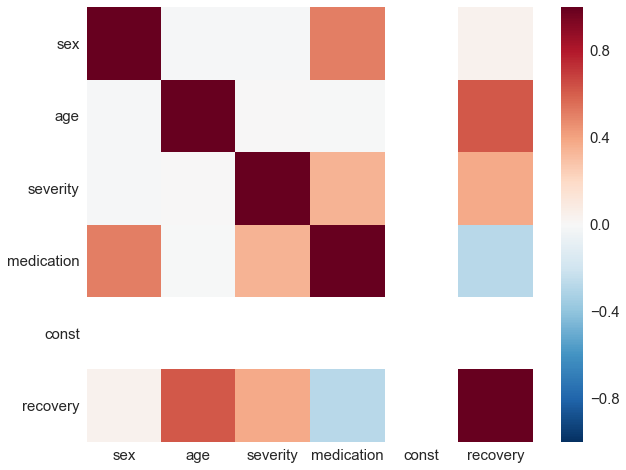

In [51]:
sns.heatmap(orig_corr, vmin=-1, vmax=1);

In [52]:
iptw_corr = weighted_corr(df_obs[sel_cols].as_matrix(), w=df_obs['iptw'].values)
iptw_corr = pd.DataFrame(iptw_corr, index=sel_cols, columns=sel_cols)
iptw_corr

,sex,age,severity,medication,const,recovery
sex,1.000000,-0.001601,-0.154496,0.087948,NaN,0.222515
age,-0.001601,1.000000,-0.028975,0.014248,NaN,0.461467
severity,-0.154496,-0.028975,1.000000,0.103541,NaN,0.369249
medication,0.087948,0.014248,0.103541,1.000000,NaN,-0.531669
const,NaN,NaN,NaN,NaN,NaN,NaN
recovery,0.222515,0.461467,0.369249,-0.531669,NaN,1.000000


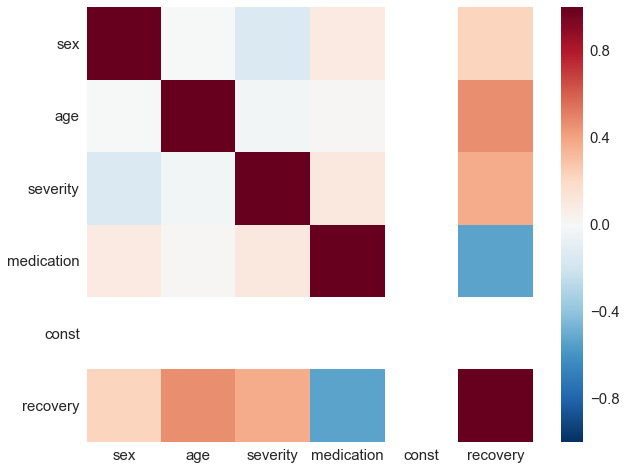

In [53]:
sns.heatmap(iptw_corr, vmin=-1, vmax=1);